In [88]:
%matplotlib nbagg

from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, img_as_float64
import elasticdeform

In [99]:
# Retrieve train images
images = io.imread('data/train-volume.tif') / 255
labels = io.imread('data/train-labels.tif') / 255
print(images.shape)
print(labels.shape)

(30, 512, 512)
(30, 512, 512)


<IPython.core.display.Javascript object>


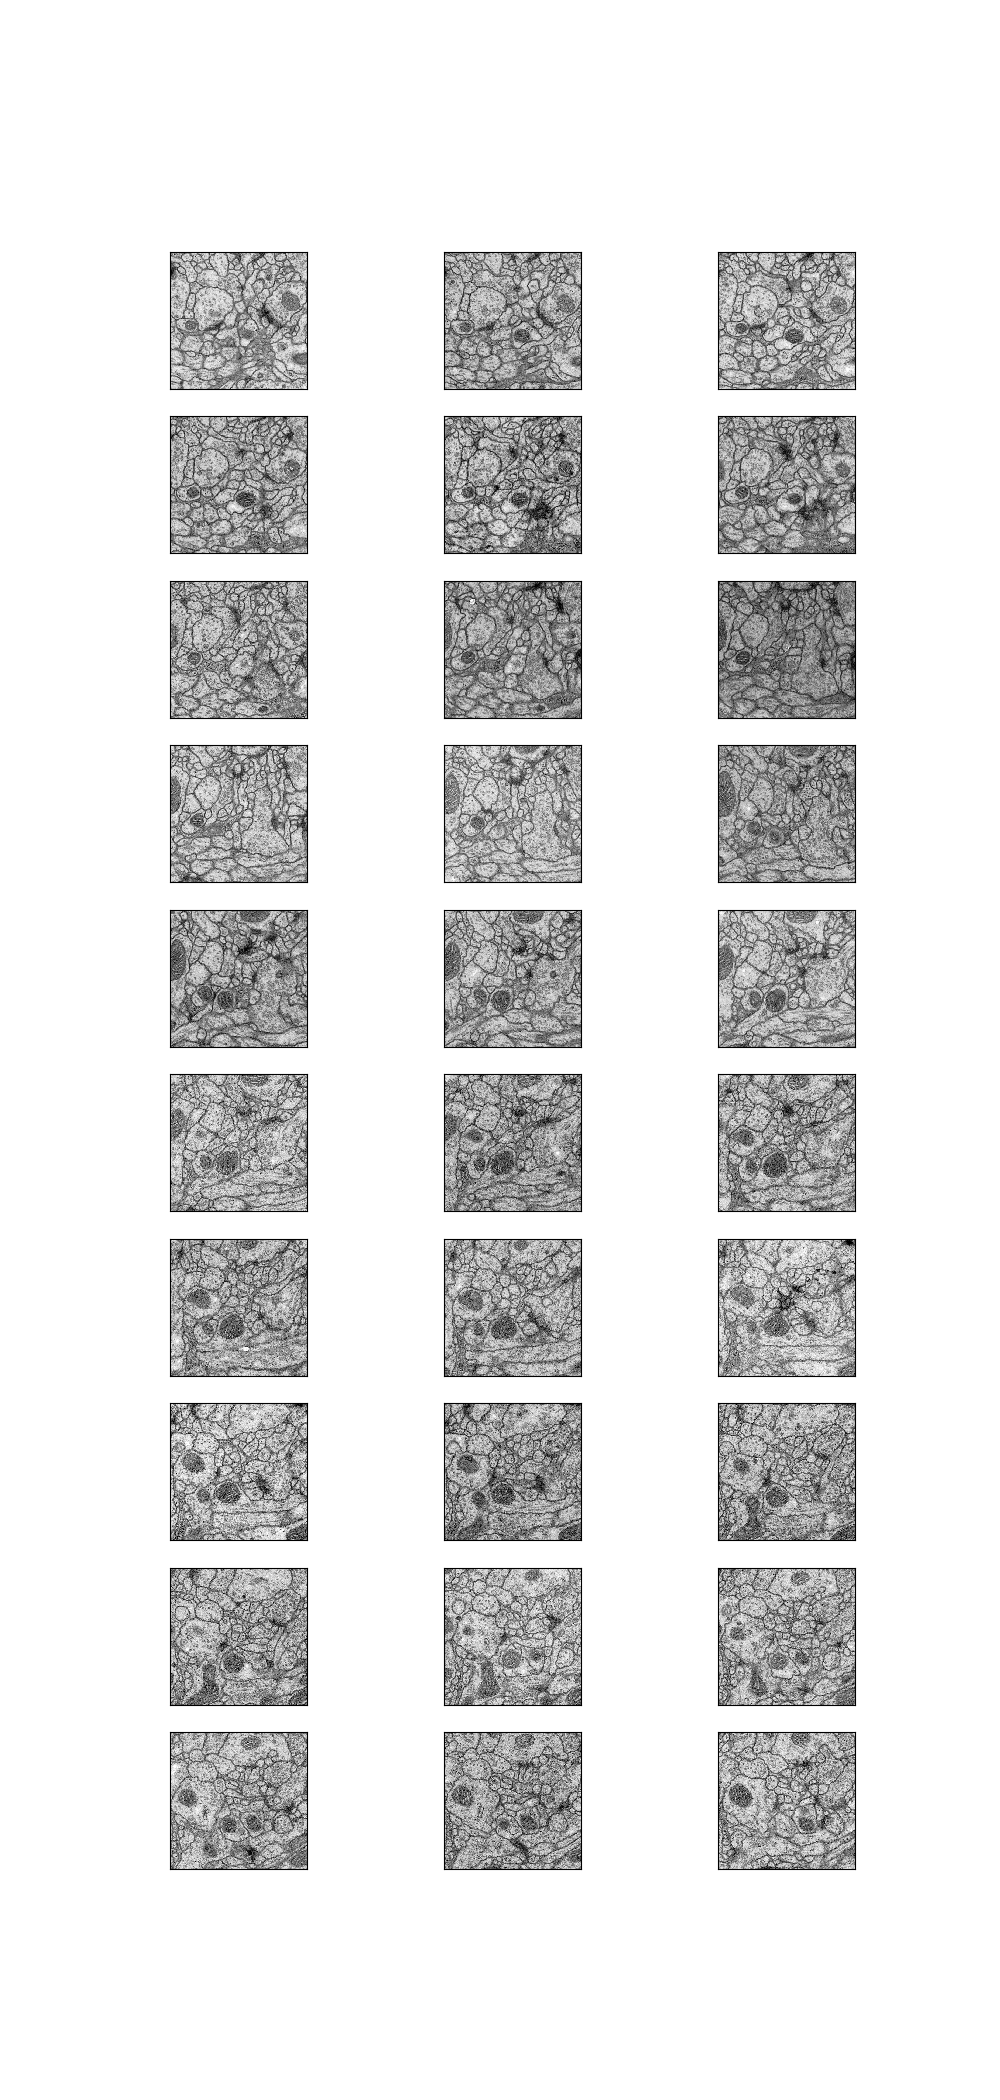

In [114]:
fig, axes = plt.subplots(figsize=(10,21), nrows=10, ncols=3)
for ax, img in zip(axes.flatten(), images):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((512,512)), cmap='Greys_r')

<IPython.core.display.Javascript object>


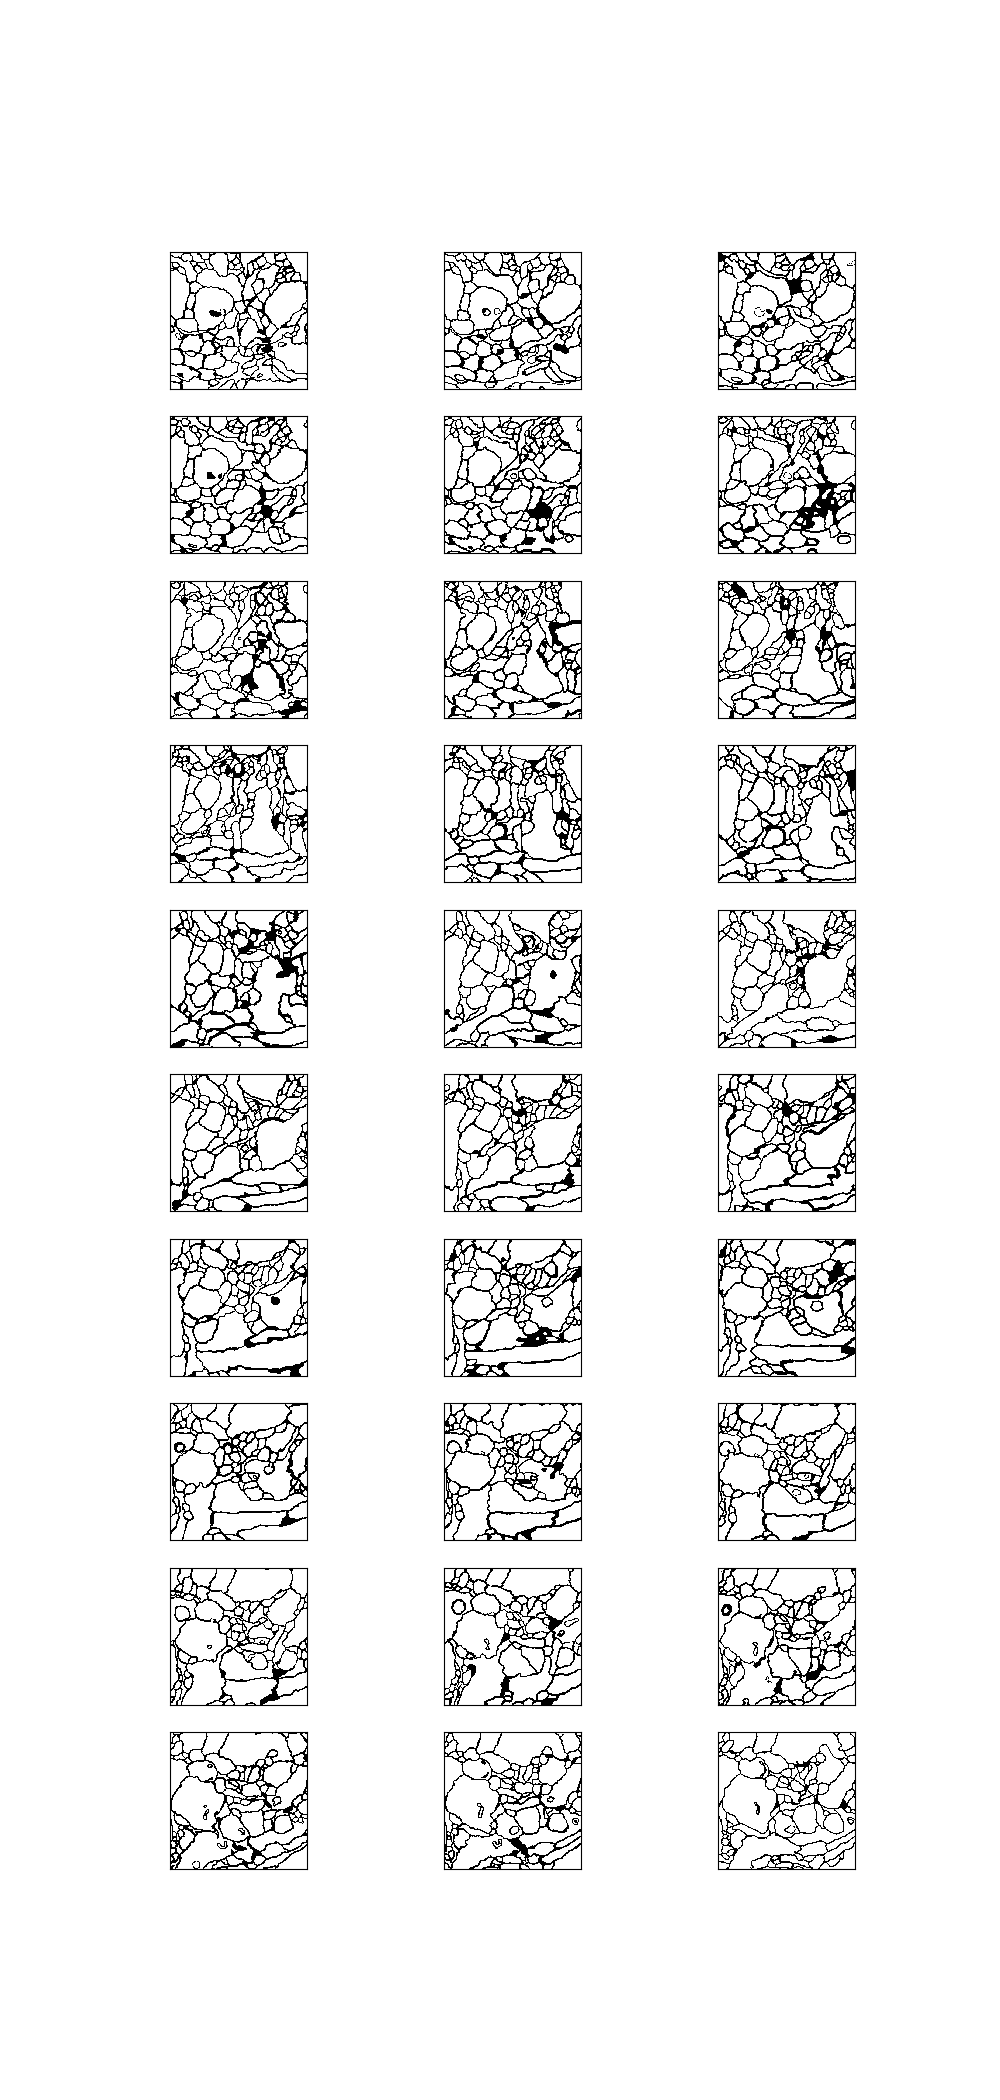

In [119]:
fig, axes = plt.subplots(figsize=(10,21), nrows=10, ncols=3)
for ax, img in zip(axes.flatten(), labels):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((512,512)), cmap='Greys_r')

<IPython.core.display.Javascript object>


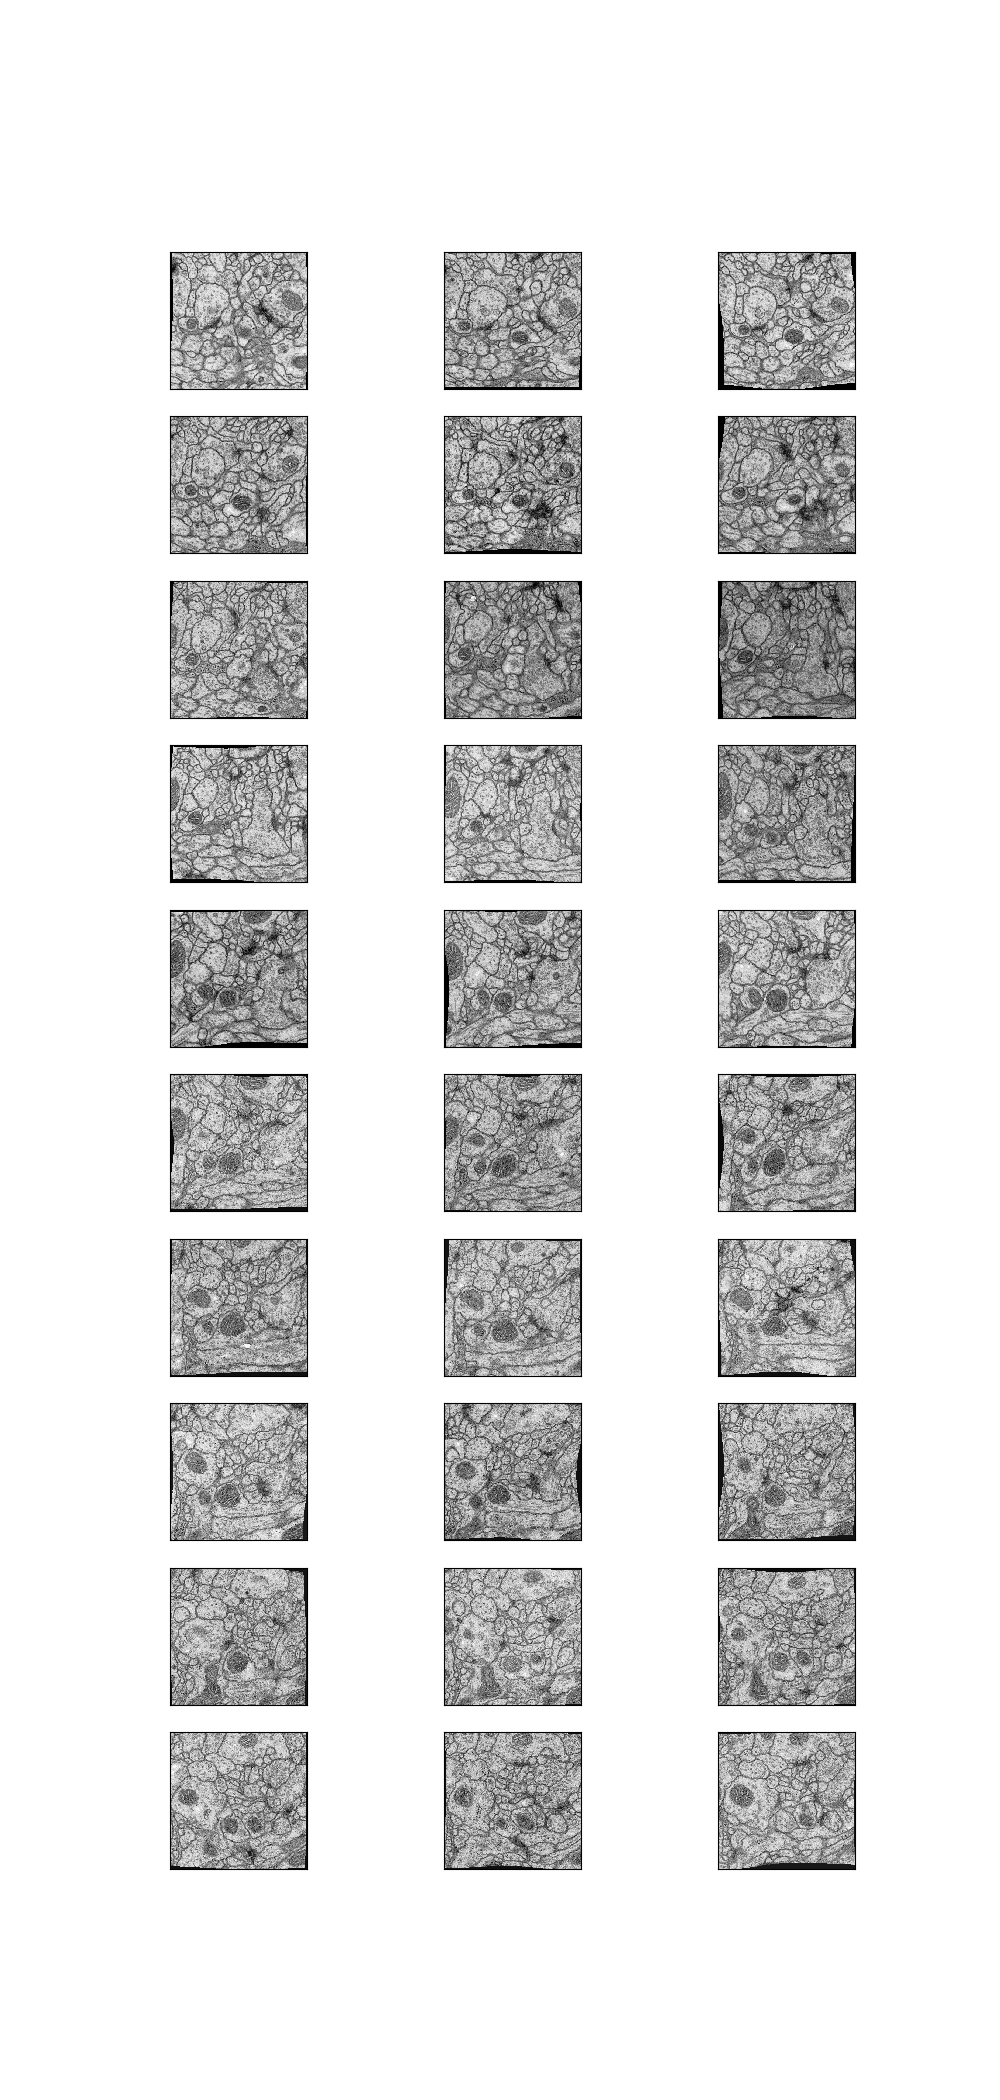

In [118]:
fig, axes = plt.subplots(figsize=(10,21), nrows=10, ncols=3)
for ax, img in zip(axes.flatten(), images):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    img = elasticdeform.deform_random_grid(img, sigma=10, points=3)
    im = ax.imshow(img.reshape((512,512)), cmap='Greys_r')

In [103]:
print(np.unique(labels))
print(np.mean(labels))

[0. 1.]
0.7803688049316406
